In [11]:
# 구글 드라이브 연동
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [19]:
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import callbacks
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications import ResNet50

In [13]:
tf.__version__

'2.4.1'

In [14]:
ori_res = ResNet50(input_shape=(150,150,3), include_top=False)
ori_res.trainable = False
ori_res.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
finetune_model = Sequential()
finetune_model.add(ori_res)
finetune_model.add(layers.GlobalAveragePooling2D())
finetune_model.add(layers.Dense(6, activation='softmax'))
finetune_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 5, 5, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 12294     
Total params: 23,600,006
Trainable params: 12,294
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
# 데이터셋 불러오기
train_datagen = ImageDataGenerator(rescale = 1./255, validation_split=0.3)
train_generator = train_datagen.flow_from_directory('/content/gdrive/MyDrive/vgg_practice_set/seg_train/seg_train', 
                                                    target_size=(150,150), color_mode='rgb',
                                                    batch_size = 64, shuffle=True, seed = 2020,
                                                    class_mode='categorical', subset='training')

valid_generator = train_datagen.flow_from_directory('/content/gdrive/MyDrive/vgg_practice_set/seg_train/seg_train', 
                                                    target_size=(150,150), color_mode='rgb',
                                                    batch_size = 64, shuffle=True, seed = 2020,
                                                    class_mode='categorical', subset = 'validation')

test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory('/content/gdrive/MyDrive/vgg_practice_set/seg_test/seg_test',
                                                  target_size=(150,150), color_mode='rgb',
                                                  batch_size=1, shuffle=False, seed = 2020,
                                                  class_mode=None) # test set setting check

STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size

Found 9826 images belonging to 6 classes.
Found 4208 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [ ]:
# callback 및 compile 설정
checkpoint = ModelCheckpoint('/content/gdrive/MyDrive/vgg_practice_set/modelcheckpoint/res_best_model.hdf5',
                             verbose = 1, monitor = 'val_accuracy', save_best_only = True)

finetune_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0005),  
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = finetune_model.fit_generator(generator = train_generator,
                              epochs = 150,
                              steps_per_epoch = STEP_SIZE_TRAIN, # train_generator.n // train_generator.batch_size
                              validation_data=valid_generator,
                              callbacks = [checkpoint],
                              validation_steps = STEP_SIZE_VALID # valid_generator.n // valid_generator.batch_size
                              )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/150
153/153 [==============================] - 3480s 23s/step - loss: 1.8361 - accuracy: 0.1876 - val_loss: 1.7151 - val_accuracy: 0.2490

Epoch 00001: val_accuracy improved from -inf to 0.24904, saving model to /content/gdrive/MyDrive/vgg_practice_set/modelcheckpoint/res_best_model.hdf5
Epoch 2/150
153/153 [==============================] - 32s 208ms/step - loss: 1.6937 - accuracy: 0.3586 - val_loss: 1.6296 - val_accuracy: 0.4558

Epoch 00002: val_accuracy improved from 0.24904 to 0.45577, saving model to /content/gdrive/MyDrive/vgg_practice_set/modelcheckpoint/res_best_model.hdf5
Epoch 3/150
153/153 [==============================] - 32s 209ms/step - loss: 1.6149 - accuracy: 0.4383 - val_loss: 1.5730 - val_accuracy: 0.4425

Epoch 00003: val_accuracy did not improve from 0.45577
Epoch 4/150
153/153 [==============================] - 32s 210ms/step - loss: 1.5579 - accuracy: 0.4680 - val_loss: 1.5298 - val_accuracy: 0.4401

Epoch 00004: val_accuracy did not improve from 0.45577

Text(0.5, 1.0, 'loss')

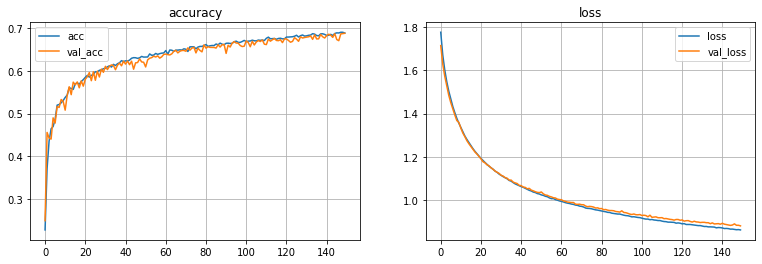

In [ ]:
# Accuracy/validation plots
h = history.history
fig = plt.figure(figsize = (13, 4))

plt.subplot(121)
plt.plot(h['accuracy'], label = 'acc')
plt.plot(h['val_accuracy'], label = 'val_acc')
plt.legend()
plt.grid()
plt.title(f'accuracy')

plt.subplot(122)
plt.plot(h['loss'], label = 'loss')
plt.plot(h['val_loss'], label = 'val_loss')
plt.legend()
plt.grid()
plt.title(f'loss')

In [15]:
# Loading weights from best model
finetune_model.load_weights('/content/gdrive/MyDrive/vgg_practice_set/modelcheckpoint/res_best_model.hdf5')

# Saving all model
finetune_model.save('/content/gdrive/MyDrive/vgg_practice_set/modelcheckpoint/res_best_model.hdf5')

# Evaluate mmodel
evaluated = finetune_model.evaluate_generator(generator=valid_generator, steps=STEP_SIZE_VALID)
print(f'Best model loss: {round(evaluated[0], 2)}')
print(f'Best model accuracy: {round(evaluated[1] * 100, 2)}%')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Best model loss: 0.88
Best model accuracy: 68.65%


In [16]:
# Predict classes in test dataset
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size
test_generator.reset()
preds = finetune_model.predict_generator(test_generator, steps = STEP_SIZE_TEST, verbose = 1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


3000/3000 [==============================] - 762s 254ms/step


In [17]:
# Creating y_true and y_pred for confusion matrix
predicted_class_indices = np.argmax(preds, axis = 1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
y_pred = [labels[k] for k in predicted_class_indices]
y_true = [labels[k] for k in test_generator.labels]

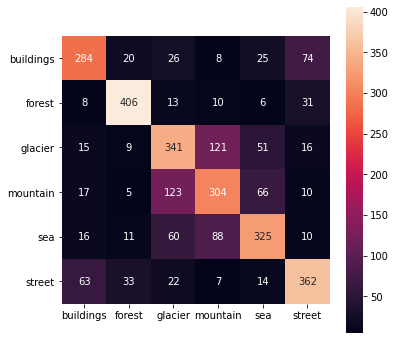

In [20]:
# Plotting confusion matrix
l = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
confusion = confusion_matrix(y_true, y_pred)
fig = plt.figure(figsize = (6, 6))
sns.heatmap(confusion, annot = True, fmt = 'd', xticklabels = l, yticklabels = l, square = True)

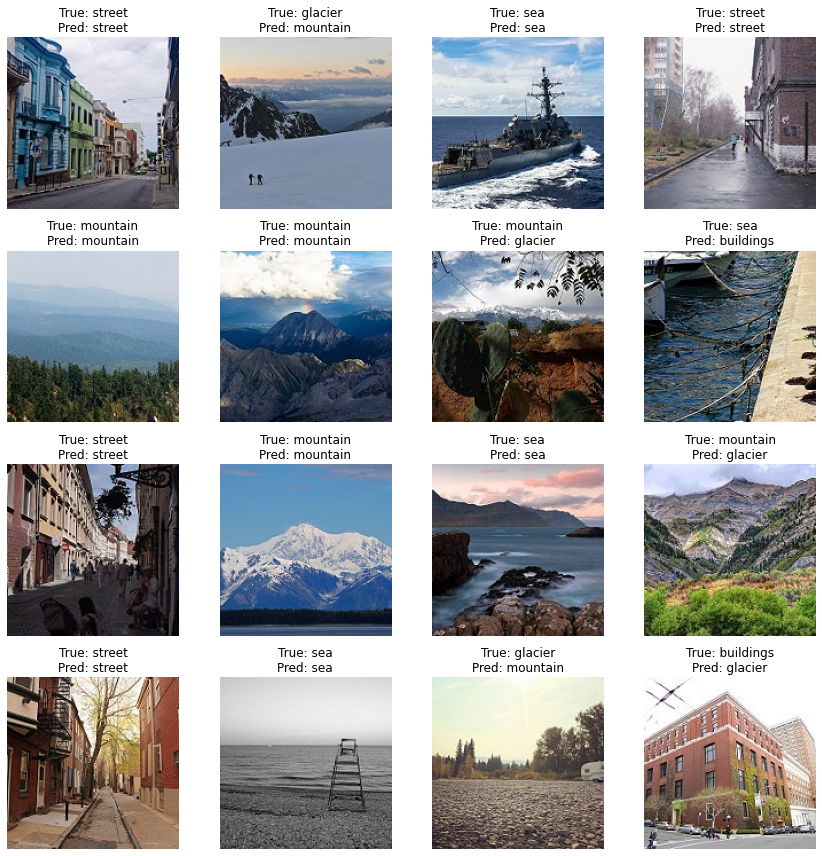

In [21]:
# Showing examples of images with true and predicted classes
filenames = test_generator.filenames
rows, cols = (4, 4)

fig = plt.figure(figsize = (12, 12))
for i in range(rows * cols):
    r = np.random.randint(0, 2999)
    image_path = '/content/gdrive/MyDrive/vgg_practice_set/seg_test/seg_test' + '/' + filenames[r]
    image = cv.imread(image_path)
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(image[:, :, ::-1])
    plt.title(f'True: {filenames[r].split("/")[0]}\nPred: {y_pred[r]}')
    plt.axis('off')

plt.tight_layout()